# Master AI4OneHealth Text Mining Practical Session: Classifying Biomedical Documents with BlueBERT

    Aidan Mannion (aidan.mannion@univ-grenoble-alpes.fr)
    Didier Schwab (didier.schwab@univ-grenoble-alpes.fr)

## Introduction

In this tutorial, we will walk through the following steps;
1. Preparing a dataset of clinical notes for training a language model
2. Understanding how pre-trained language models are built and used (transfer learning) and how this procedure can be useful in clinical applications
3. Create a text classification model that exploits the hidden representations of an encoder based on the transformer architecture (à la [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)))
4. Train this model and test its performance

We will be using the following tools & resources for Python;
- [PyTorch](https://pytorch.org/docs/stable/index.html) : an open-source library for machine learning
- [transformers](https://huggingface.co/docs/transformers/index) by [Hugging Face](https://huggingface.co/): a Pytorch-based library for automatic language processing and in particular Transformer-type neural models (such as BERT)
- [tokenizers](https://huggingface.co/docs/tokenizers/python/latest/), also provided by Hugging Face: a Pytorch-based library for tokenisation, explicitly designed to work with the Transformers library
- Google Colab, which hosts this Jupyter Notebook. Before starting the work, you may want to consult some introductory pages on [Colab](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l01c01_introduction_to_colab_and_python.ipynb#scrollTo=YHI3vyhv5p85) or [jupyter notebooks](https://realpython.com/jupyter-notebook-introduction/)


#### Further study

If you'd like to know more about the Natural Language Processing (NLP) techniques we will be using in this tutorial, feel free to check out the following;
- The original [paper](https://arxiv.org/abs/1706.03762) introducing transformer language models, or [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html) great tutorial.
- The original [paper](https://arxiv.org/abs/1810.04805v2) introducing BERT, an application of the transformer architecture that broke new ground in NLP.
- [BioBERT](https://arxiv.org/abs/1901.08746v4), a version of BERT trained on PubMed articles to adapt it for biomedical tasks.
- [ClinicalBERT](https://arxiv.org/abs/1904.03323), a language model that extends BioBERT to clinical applications by training it on text documents from EHR records.
- [BLUE](https://arxiv.org/pdf/1906.05474.pdf), a benchmark suite for biomedical language processing tasks (we will be using a BERT model developed as part of this project in this tutorial).


#### Installing the Hugging Face libraries

Colab runtime instances come with a Python environment with several pre-installed libraries, running on a Linux OS. However, if you are using Colab, you must first install the HuggingFace libraries, which are not pre-installed.

To execute a Unix command on a Jupyter Notebook, an exclamation mark must be placed before the command: `!command`.

In [1]:
!pip install transformers tokenizers accelerate

Defaulting to user installation because normal site-packages is not writeable


Once these are successfully installed in our Colab environment, we can import the libraries we need.

In [2]:
import torch
import transformers

**GPU**

Training our neural network requires a lot of matrix calculations. If available, we can use a graphics processor (GPU) to perform these calculations faster. On Colab, you can use a GPU by clicking on _Runtime -> Change runtime type_ and then selecting the "GPU" option from the drop-down _Hardware Accelerator_ menu.

In [3]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [4]:
torch.cuda.is_available()

True

In [5]:
if torch.cuda.is_available():
    print('GPU available!')
    device = torch.cuda.current_device()
else:
    print('GPU unavailable - CPU will be used for all calculations')
    device = None

GPU available!


In [6]:
torch.cuda.current_device()

0

## NLP Application Task: Supervised Document Classification

Document classification is a very common application of natural language processing & machine learning techniques. In this paradigm, a "document" can refer to any textual data point, from articles to text messages, and "supervised" means we are restricting our attention to [supervised ML](https://en.wikipedia.org/wiki/Supervised_learning) - tasks with pre-defined target categories. Some widely-known general uses of document classification in a supervised learning context include spam e-mail detection and recommendation engines.

### Medical Document Classification
Automatic classification of biomedical and/or clinical documents has the potential to ameliorate many aspects of both practice and research. Potential applications of document classification range from the categorisation of medical articles for literature reviews to the detection of abnormalities in patient discharge reports, and many other tasks that can be time-intensive for medical practitioners.

The goal of this tutorial is to use a pre-trained transformer language model provided through the Hugging Face API to train a classifier to associate the relevant hallmarks with PubMed abstracts. This will involve the following steps;
- Loading and preprocessing the text corpus
- Tokenising the dataset, i.e. using the vocabulary that the language model has learned in the pre-training phase to associate identifiers with the words in our training set
- Loading the neural weights of the language model and using them to train a classifier 

## Dataset: Hallmarks of Cancer

The dataset we will be using in this tutorial is the [Hallmarks of Cancer](https://academic.oup.com/bioinformatics/article/32/3/432/1743783) corpus, which contains 1,499 PubMed article abstracts annotated by experts according to their relevance to the ten known _hallmarks of cancer_;
- Sustaining proliferative signaling (PS)
- Evading growth suppressors (GS)
- Resisting cell death (CD)
- Enabling replicative immortality (RI)
- Inducing angiogenesis (A)
- Activating invasion & metastasis (IM)
- Genome instability & mutation (GI)
- Tumor-promoting inflammation (TPI)
- Deregulating cellular energetics (CE)
- Avoiding immune destruction (ID)

In [7]:
# fetch the dataset
!wget --no-check-certificate "https://gricad-gitlab.univ-grenoble-alpes.fr/manniona/hoc-dataset/-/archive/main/hoc-dataset-main.zip" -O "hoc.zip"

--2022-12-27 23:50:42--  https://gricad-gitlab.univ-grenoble-alpes.fr/manniona/hoc-dataset/-/archive/main/hoc-dataset-main.zip
Resolving gricad-gitlab.univ-grenoble-alpes.fr (gricad-gitlab.univ-grenoble-alpes.fr)... 129.88.175.2
Connecting to gricad-gitlab.univ-grenoble-alpes.fr (gricad-gitlab.univ-grenoble-alpes.fr)|129.88.175.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888413 (868K) [application/zip]
Saving to: 'hoc.zip'

     0K .......... .......... .......... .......... ..........  5%  431K 2s
    50K .......... .......... .......... .......... .......... 11%  995K 1s
   100K .......... .......... .......... .......... .......... 17% 6,24M 1s
   150K .......... .......... .......... .......... .......... 23%  527K 1s
   200K .......... .......... .......... .......... .......... 28% 54,2M 1s
   250K .......... .......... .......... .......... .......... 34% 3,16M 1s
   300K .......... .......... .......... .......... .......... 40% 1,27M 0s
   350K 

In [8]:
# extract the data
import zipfile

zip_ref = zipfile.ZipFile('hoc.zip', 'r') 
# Extract all the contents of zip file in current directory
zip_ref.extractall()
zip_ref.close()

#### Loading the data
The corpus is divided into three parts, as is standard practice in machine learning;
1. ``train``: (70% of the data) the training set, on which the classifier will learn it's parameters
2. ``dev``: (10% of the data) the _development_ set, used to evaluate the generalisation performance of the model as it is trained, and choose better hyperparameter values
3. ``test``: (20% of the data) the test or "hold-out" set, used only after all training has been completed, to evaluate the "true" generalisation performance of the model.

For now we will only be working with the training and development sets.

In [9]:
from pandas import read_csv

train_rawtext = read_csv('hoc-dataset-main/train.tsv', sep='\t', index_col=0)
print(f'Train set: {len(train_rawtext)} rows and {len(train_rawtext.columns)} columns')
dev_rawtext = read_csv('hoc-dataset-main/dev.tsv', sep='\t', index_col=0)
print(f'Development set: {len(dev_rawtext)} rows and {len(dev_rawtext.columns)} columns')

Train set: 10527 rows and 3 columns
Development set: 1496 rows and 3 columns


The dataset is in the form of a table with three columns - each row corresponds to a sentence from one of the abstracts, along with the relevant annotation, as follows;
1. ``index``: an identifier with the PubMed ID of the abstract and the sentence number of the data point; for example, the third sentence of the abstract with PubMed ID 123456 will have ``1232456_s3`` in this field.
2. ``sentence``: the sentence itself.
3. ``labels``: either one of the ten abbreviations listed above, corresponding to the hallmark of cancer most relevant to the sentence, or ``NONE``.

It is always good to take a look at the first few rows of the dataframe to check that we have all the data that we want.

In [10]:
train_rawtext.head(5)

,index,sentence,labels
0,11724768_s0,Ghrelin was identified in the stomach as an en...,NONE
1,11724768_s1,"GHS-R is found in various tissues , but its fu...",NONE
2,11724768_s2,Here we show that GHS-R is found in hepatoma c...,NONE
3,11724768_s3,Exposure of these cells to ghrelin caused up-r...,PS
4,11724768_s4,"Unlike insulin , ghrelin inhibited Akt kinase ...",NONE


#### Cleaning the text
In order for the tokenizer to properly process the text, we need to remove punctuation and non-alphabetic characters (BERT-style models usually do not deal well with numeric characters). For this we'll use the built-in Python library for dealing with regular expressions (regex), [re](https://docs.python.org/3/library/re.html).

The BERT variant we are using in this work was trained on lower-case text, so we also map all capital letters to  lower case. Some of these models do use a vocabulary with capital letters as well; be sure to check the details of the pre-training corpus when experimenting with other models. 

In [11]:
# Regex library
import re

**Exercise:** The ``clean_sentence`` function below is only partially completed. You will need to write the parts that do the following;
- remove extra spaces (i.e. ``" Foo  Bar  "`` $\rightarrow$ ``" Foo Bar "``)
- remove trailing spaces (i.e. ``" Foo Bar "`` $\rightarrow$ ``"Foo Bar"``
- map to lowercase (i.e. ``"Foo Bar"`` $\rightarrow$ ``"foo bar"``)

_Hint:_ The ``re.sub`` function used to replace non-alphabetic characters with spaces could be useful again, as well as some of the built-in methods of Python's ``str`` type.

In [12]:
def clean_sentence(sent: str):
    '''Function that takes in a string and outputs a cleaned version without non-alphabetic
    characters'''
    
    # replace non-alphabetic characters with spaces
    sent = re.sub('[^A-Za-z]', ' ', sent)
    sent = re.sub('\s+', ' ', sent)
    
    return sent.strip().lower()

First let's look at a quick example to check that this function works as intended

In [13]:
# pull out a random sentence from the dataset
sample_sentence = train_rawtext.sentence.sample(1).tolist().pop()
print(f'Raw text:\n{sample_sentence}')
cleaned_sentence = clean_sentence(sample_sentence)
print(f'\nCleaned text:\n{cleaned_sentence}')

Raw text:
METHODS The effects of TMZ and BG on apoptosis , cell growth , the mitotic index , cell cycle distribution , and protein expression were studied by TUNEL , cell counting , flow cytometry , and Western blot analysis , respectively .

Cleaned text:
methods the effects of tmz and bg on apoptosis cell growth the mitotic index cell cycle distribution and protein expression were studied by tunel cell counting flow cytometry and western blot analysis respectively


We then apply the text cleaning function in a vectorised manner to all the sentences in our dataset. This is made easy by the ``apply`` method in pandas.

In [14]:
train_cleantext = train_rawtext.assign(sentence=train_rawtext.sentence.apply(clean_sentence))
dev_cleantext = dev_rawtext.assign(sentence=dev_rawtext.sentence.apply(clean_sentence))

We also need to numerically encode the class labels, as the classifier expects integer labels, i.e. $\{0,1\}$ for binary classification, $\{0,10\}$ in our case. All we need to do is define an ordering of the labels and Python will assign integers to them automatically.

In [15]:
abbrev_labels = ('NONE', 'PS', 'GS', 'CD', 'RI', 'A', 'IM', 'GI', 'TPI', 'CE', 'ID')
train_cleantext.labels = train_cleantext.labels.apply(lambda x: abbrev_labels.index(x))
dev_cleantext.labels = dev_cleantext.labels.apply(lambda x: abbrev_labels.index(x))

We now have a new version of the datasets which are ready for processing:

In [16]:
train_cleantext.head(5)

,index,sentence,labels
0,11724768_s0,ghrelin was identified in the stomach as an en...,0
1,11724768_s1,ghs r is found in various tissues but its func...,0
2,11724768_s2,here we show that ghs r is found in hepatoma c...,0
3,11724768_s3,exposure of these cells to ghrelin caused up r...,1
4,11724768_s4,unlike insulin ghrelin inhibited akt kinase ac...,0


## Tokenisation

The `tokenizers` library provides tools to tokenise input text data according to the model that will be used to process them (see [the documentation](https://huggingface.co/docs/transformers/tokenizer_summary) for more details).

In this assignment we will used a pre-trained version of the transformer language model BERT that is adapted for biomedical tasks, known as BlueBERT, which will be described in more detail in the next section.

In [17]:
MODEL_NAME = 'bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12'

**Exercise:** What does ``L-12_H-768_A-12`` signify in the model name?

**Answer:**

The string "L-12_H-768_A-12" is a common naming convention used to describe the architecture of the BERT (Bidirectional Encoder Representations from Transformers) model. BERT is a transformer-based language model developed by Google that has been widely used for natural language processing (NLP) tasks.

The string "L-12_H-768_A-12" indicates that the BERT model has 12 layers (L-12), each with a hidden size of 768 (H-768), and 12 attention heads (A-12). The hidden size refers to the number of neurons or units in each layer of the BERT model, and the attention heads refer to the number of attention mechanisms used by the model.

Here is a breakdown of the different components of the string:

- L: The number of layers in the BERT model. A larger number of layers typically results in a more powerful model, but also requires more computational resources to train and run.

- H: The hidden size or number of neurons in each layer of the BERT model. A larger hidden size typically results in a more powerful model, but also requires more computational resources to train and run.

- A: The number of attention heads used by the BERT model. Attention mechanisms are used to weight the importance of different parts of the input text when generating an output. A larger number of attention heads typically results in a more powerful model, but also requires more computational resources to train and run.

The string "L-12_H-768_A-12" is just one example of a BERT model architecture, and there are many other variations of BERT models with different numbers of layers, hidden sizes, and attention heads.

In [18]:
from transformers import AutoTokenizer

Because different input sequences have different lengths, their encodings cannot all be used in the same [tensor](https://pytorch.org/docs/stable/tensors.html) object as they are. That's why we need to fix a parameter (``MAX_LEN``) to specify the sequence length we would like to use.

In [19]:
MAX_LEN = 90

In [20]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

The output of the tokenizer (an object of type ``BatchEncoding``) has two main components we should focus on;
- ``input_ids``: These are token indices, numerical representations of tokens based on the model's vocabulary.
- ``attention_mask``: A binary tensor indicating to the model which tokens it should attend to, for sequences shorter than ``MAX_LEN`` that need to be padded.

In [21]:
def do_tokenisation(list_, max_length):
    tokeniser_output = tokenizer(
        list_,
        padding='max_length',  # pad shorter sequences to max_length
        truncation=True,  # truncate longer sequences to max_length
        max_length=max_length
    )
    for encoding in tokeniser_output:
        tokeniser_output[encoding] = torch.tensor(tokeniser_output[encoding])
        
    return tokeniser_output

In [22]:
train_tokeniser_output = do_tokenisation(train_cleantext.sentence.tolist(), MAX_LEN)
dev_tokeniser_output = do_tokenisation(dev_cleantext.sentence.tolist(), MAX_LEN)


Let's have a look at an example of the encodings produced by the tokenizer.

In [23]:
batch_idx = 0
original_sentence = train_cleantext.sentence[batch_idx]
print(f'Input sentence:\n{original_sentence}\n')
tokens = train_tokeniser_output.tokens(batch_idx)
print(f'Tokens:\n{tokens}\n')
input_ids = train_tokeniser_output['input_ids'][batch_idx]
print(f'Input IDs:\n{input_ids}\n')
attention_mask = train_tokeniser_output['attention_mask'][batch_idx]
print(f'Attention Mask:\n{attention_mask}\n')

Input sentence:
ghrelin was identified in the stomach as an endogenous ligand specific for the growth hormone secretagogue receptor ghs r

Tokens:
['[CLS]', 'g', '##hre', '##lin', 'was', 'identified', 'in', 'the', 'stomach', 'as', 'an', 'end', '##ogen', '##ous', 'ligand', 'specific', 'for', 'the', 'growth', 'hormone', 'secret', '##ago', '##gue', 'receptor', 'g', '##hs', 'r', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

Input IDs:
tensor([  101,  1043, 28362,  4115,  2001, 

In [24]:
tokens = train_tokeniser_output.tokens(0)
print(f'Tokens:\n{tokens}\n')

Tokens:
['[CLS]', 'g', '##hre', '##lin', 'was', 'identified', 'in', 'the', 'stomach', 'as', 'an', 'end', '##ogen', '##ous', 'ligand', 'specific', 'for', 'the', 'growth', 'hormone', 'secret', '##ago', '##gue', 'receptor', 'g', '##hs', 'r', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']



#### Exercises

1. What does the output of the tokeniser represent? 
2. What are the special tokens introduced by the tokenizer? What is their function?
3. Why do some tokens start with ## (for example, ##rea ##der)?
4. Note that the tokenizer that we use has been pre-trained. Why does a tokenizer like this require pre-training?
5. The architecture we will be using to process the text handles sequences with a maximum length of 512 (`MAX_LEN=512`). Check if this length is suitable for our data. In other words, look at the length distribution of the texts we have to classify and decide whether it would be advantageous to reduce `MAX_LEN` in order to reduce the processing time of the sequences. 

**Answers**

**1-What does the output of the tokeniser represent?**
The AutoTokenizer is a class in the transformers library that is used to automatically preprocess text data and convert it into a numerical representation that can be fed into a transformer model.

The AutoTokenizer takes a piece of text as input and output a list of tokens, where each token represents a word or subword in the input text. The tokens are produced by applying a process called tokenization, which involves splitting the input text into a sequence of tokens. The AutoTokenizer class uses a pre-trained tokenization model to perform this task, and it can handle a wide range of natural language text.

The output of the AutoTokenizer can be used as input to a transformer model for a variety of NLP tasks, such as language translation, text classification, and question answering. The transformer model processes the tokens and produces a prediction or output based on the input text.

The output of the tokenizer (an object of type BatchEncoding) contains tokens, input_id an attention_mask.... so it is a sequence of tokens that have been converted into numerical form using a process called tokenization. The numerical representation of the tokens is called the input ID. The input ID is a list of integers, where each integer corresponds to a token in the input text. The integers are assigned to each token according to a pre-defined vocabulary, which maps each token to a unique integer.

The attention mask is a binary sequence that is used to specify which tokens in the input text should be attended to by the transformer model. The attention mask is used to exclude padding tokens (tokens that are added to the input text to ensure that all input sequences have the same length) from the model's attention.


**2-What are the special tokens introduced by the tokenizer? What is their function?**

The BERT tokenizer introduces several "special tokens" that have specific functions in the BERT model. These special tokens are added to the input text as part of the tokenization process and are used to provide additional information to the model about the input text.

Here are some of the special tokens that are used by the BERT tokenizer:

[CLS]: This token is added to the beginning of the input text and is used to represent the entire input sequence. It is used by the BERT model to generate a single output for the entire input sequence.

[SEP]: This token is added between the input text and any additional context (such as a question or answer in a Q&A task). It is used to separate the input text from the additional context and to indicate the end of the input text.

[PAD]: This token is added to the input text to ensure that all input sequences have the same length. It is used to pad the input text to the desired length.

[UNK]: This token is used to represent out-of-vocabulary (OOV) words that are not included in the BERT vocabulary.

The BERT tokenizer also includes a technique called wordpiece tokenization, which involves breaking words into subwords if they are not included in the BERT vocabulary. This allows the BERT model to handle a wider range of words and to capture the meaning of rare or OOV words by combining subwords that represent their meanings.




**3-Why do some tokens start with ## (for example, ##rea ##der)?**

In natural language processing (NLP), it is common to use a special notation to indicate that a token is a subword or a part of a word that has been split by the tokenizer. This is often done to handle words that are not in the tokenizer's vocabulary, or to split compound words into smaller units that are more useful for certain NLP tasks.

One way to indicate that a token is a subword is to prefix it with a special symbol, such as "##". For example, if you have a tokenizer that is trained on a vocabulary of common English words, and you want to tokenize the following compound word:

"modulates"

The tokenizer might split it into the following tokens:

"mod", "##ulates"

The "##" prefix indicates that the two tokens together represent the original compound word "bicycle".

This approach is often used in combination with subword-based tokenizers, such as the BPE (byte pair encoding) or WordPiece tokenizers, which split words into subwords based on statistical patterns in the training data. By breaking words into smaller units, these tokenizers can handle out-of-vocabulary words and rare words more effectively, and can also reduce the size of the vocabulary needed for a given NLP task.

However, keep in mind that the specific notation and rules for handling subwords can vary depending on the specific tokenizer and NLP toolkit being used. You should refer to the documentation of the specific tool you are using for more information.



**4-Note that the tokenizer that we use has been pre-trained. Why does a tokenizer like this require pre-training?**

Pre-training a tokenizer involves training the tokenizer on a large dataset of text to learn how to tokenize the text in a way that is effective for a specific NLP task. Pre-trained tokenizers have been trained on large datasets of text and have learned how to perform tokenization in a way that is effective for a specific NLP task.

There are several reasons why a tokenizer in NLP requires pre-training:

1-Tokenization is a complex task that requires a deep understanding of natural language. Pre-trained tokenizers have been trained on large datasets of text (which is very resource demanding and costly) and have learned how to perform tokenization in a way that is effective for a specific NLP task.

2-Pre-trained tokenizers have been trained on large datasets of text and have learned how to handle a wide range of natural language text. This makes them more effective at tokenizing text than tokenizers that have not been pre-trained.

3-Pre-trained tokenizers can handle out-of-vocabulary (OOV) words and rare words more effectively than tokenizers that have not been pre-trained. This is because pre-trained tokenizers have learned how to split words into subwords or characters to represent their meanings.

4-Pre-trained tokenizers can improve the performance of NLP models by providing a high-quality representation of the input text. This is because pre-trained tokenizers have been trained on large datasets of text and have learned how to tokenize the text in a way that is effective for a specific NLP task.




**5-The architecture we will be using to process the text handles sequences with a maximum length of 512 (MAX_LEN=512). Check if this length is suitable for our data. In other words, look at the length distribution of the texts we have to classify and decide whether it would be advantageous to reduce MAX_LEN in order to reduce the processing time of the sequences.**

In [25]:
## YOUR CODE HERE (Exercise 5)
import numpy as np
import matplotlib.pyplot as plt
L1=train_tokeniser_output.attention_mask.tolist()
print(max(np.sum(L1,1)))
L2=dev_tokeniser_output.attention_mask.tolist()
print(max(np.sum(L2,1)))


90
90


(array([ 72., 275., 461., 330., 180.,  97.,  46.,  20.,   8.,   7.]),
 array([ 6. , 14.4, 22.8, 31.2, 39.6, 48. , 56.4, 64.8, 73.2, 81.6, 90. ]),
 <BarContainer object of 10 artists>)

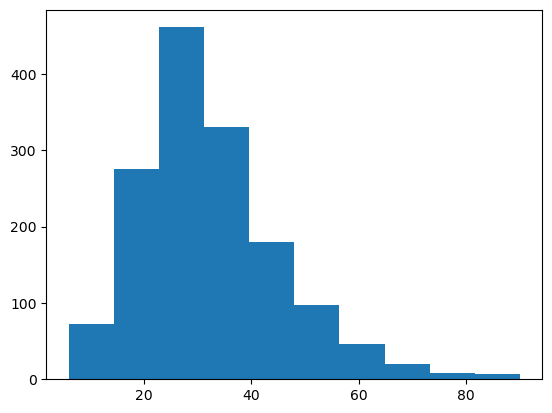

In [26]:
plt.hist(np.sum(L2,1))


(array([ 187., 1571., 3124., 2362., 1738.,  842.,  374.,  182.,   72.,
          75.]),
 array([ 3. , 11.7, 20.4, 29.1, 37.8, 46.5, 55.2, 63.9, 72.6, 81.3, 90. ]),
 <BarContainer object of 10 artists>)

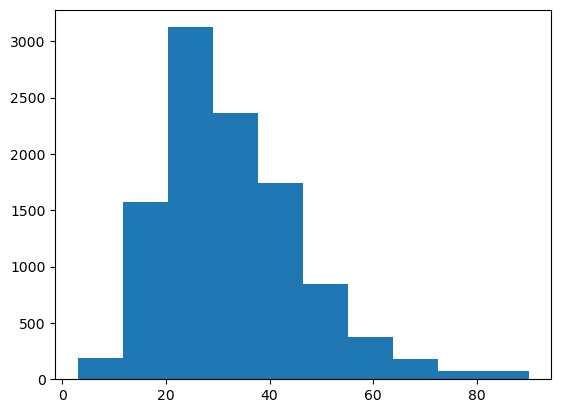

In [27]:
plt.hist(np.sum(L1,1))

We can see that the largest sentence in our training and validation dataset is 149 so setting the MAX_LEN=150 seems plausible and would avoid using uselessly more computing power than we need. we can  possibly lower this value even more if it does not impact negatively the performance of our model and this would require further testing and comparing. Also according to the histograms it would be advisable to use Max_LEN between 80 and 100 if it dows not effect significatly our results ad we would like to have a better computing performance

## Language Model

In this section we will use the Hugging Face API to load the pre-trained weights of a transformer language model for inference. 

In [28]:
from transformers import AutoConfig, AutoModelForSequenceClassification

The ``config`` attribute contains hyperparameter values including vocabulary size, dropout probabilities, and architectural specifications; feel free to inspect them and try to understand what they mean and how they relate to the course material.

In [29]:
model_config = AutoConfig.from_pretrained(MODEL_NAME)
print(model_config)

BertConfig {
  "_name_or_path": "bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



By default, the output size of the classification layer (corresponding to the number of different classes we want to identify) is 2. However, we have 10 hallmarks of cancer to classify, plus `NONE`, so we have an 11-class classification problem. This means we need to tell the model to expect 11 different class labels and adjust its output size accordingly. We do this by setting the `num_labels` configuration parameter.

In [30]:
model_config.num_labels = 11

The ``model`` object we use here is an instantiation of the pre-trained [BlueBERT](https://github.com/ncbi-nlp/bluebert) model with an extra classification layer added. 

In [31]:
model = AutoModelForSequenceClassification.from_config(model_config)

### Optimiser
Neural networks require an optimisation strategy to implement backpropagation. We will use the [Adam](https://arxiv.org/pdf/1412.6980.pdf) algorithm, a widely-used method for transformer architectures.

In [32]:
from transformers import AdamW

At this point in the implementation, we choose the learning rate to use in backpropagation: a parameter that controls the step sizes taken across the loss landscape by the optimiser at each step of training. This is a hyperparameter that has no _a priori_ optimal value; you can play around with the value to see how it affects the performance of our classifier.

In [33]:
# the constructor function requires the parameters of the language model and the learning rate as input
optimiser = AdamW(tuple(model.parameters()), lr=2e-5,eps=2e-30)

D:\WORK\AI4oneH\Anaconda\envs\tf-gpu\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Custom Datasets & Data Loaders
For efficiency, we will use the Pytorch ``DataLoader`` object to pass the tokens to the model.

In [34]:
from torch.utils.data import Dataset, DataLoader

For most Pytorch projects, you will need to define a custom dataset class that subclasses the built-in one.

In [35]:
# here we define a simple subclass of the Pytorch Dataset object: the DataLoader by default will access the amount
# of data points stored by instances of this subclass, as well as indexing it, so we have to overwrite the __len__
# and __getitem__ methods to make sure it will behave as we would like

class ClassificationDataset(Dataset):
    def __init__(self, tokeniser_output: transformers.BatchEncoding, labels: torch.Tensor):
        super().__init__()
        self.__dict__.update(tokeniser_output)
        self.labels = labels
        self.keys = tuple(tokeniser_output.keys()) + ('labels',)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx: int):
        return {key: getattr(self, key)[idx] for key in self.keys}

In [36]:
train_labels = torch.tensor(train_cleantext.labels.values, dtype=torch.int64)
dev_labels = torch.tensor(dev_cleantext.labels.values, dtype=torch.int64)

train_dataset = ClassificationDataset(train_tokeniser_output, train_labels)
dev_dataset = ClassificationDataset(dev_tokeniser_output, dev_labels)

At this point we select another hyperparameter, the _batch size_, i.e. the number of sentences to process at each training step. A higher batch size will result in more effective backpropagation steps, as the model will have "seen" more training examples before calculating the adjustment to make to its parameters, but a lower batch size will result in more efficient training as not as many examples need to be loaded into memory at once.

In [37]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)

## Training a Classifier
To fine-tune the BlueBERT word embeddings for our document classification task, we use the ``[CLS]`` token from the final layer of the transformer neural network to predict the relevant class for each sentence. To output class probabilities based on the word embedding vectors, a linear prediction layer is stacked on top of the transformer network, which will learn weight parameters $w$ that correspond to the optimal transformation of the ``[CLS]`` vector into a vector of scores for each class in the output space (usually called _logits_). To generate class probabilities from the logit vector, the [softmax function](https://en.wikipedia.org/wiki/Softmax_function) is applied:

$$
\phi_w:\mathbb{R}^{d_{\text{EMB}}}\rightarrow\mathbb{R}^{d_{\text{CLASS}}} \\
\text{Classifier}\left(x_{\text{CLS}}\right)=\text{softmax}\left(\phi_w\left(x_{\text{CLS}}\right)\right)
$$

For the model we use in this tutorial, we have embedding dimension $d_{\text{EMB}}=768$ and because we have ten hallmarks of cancer plus the absence of a hallmark, we have output dimension $d_{\text{CLASS}}=11$.

To predict a single class, however, we just need to pick out the dimension of the logit vector with the highest score:

$$\text{Predicted Class}=\text{argmax}\left(\phi\left(x_{\text{CLS}}\right)\right)$$

### Using GPUs
Graphical Processing Units (GPUs) are optimised for very fast parallel matrix calculations and are thus widely used for training neural networks. In practice, for models of the scale of BERT, GPUs are necessary to be able to perform experiments in reasonable timeframes (although pre-training still often requires several days of runtime on multiple GPUs).

Communicating data & instructions for calculations between CPUs and GPUs can be a tricky engineering task, especially when there are multiple machines involved, but luckily, once again, Hugging Face provides a very simple API that allows us to easily implement GPU training and parallelism, called [Accelerate](https://huggingface.co/docs/accelerate/).

In [38]:
from accelerate import Accelerator

accelerator = Accelerator()

With Accelerate, we simply wrap our training objects using the ``prepare`` method - this creates GPU-compatible objects that can be used for distributed training.

In [39]:
if device is not None:
    model, optimiser, train_dataloader, dev_dataloader = accelerator.prepare(
        model, optimiser, train_dataloader, dev_dataloader
    )

### Evaluation Metrics
The last thing to prepare before launching the training is our method of evaluating the model. The best metric to use can vary depending on the classification task in question. The standard metric for the Hallmarks of Cancer classification task is the [F1-score](https://en.wikipedia.org/wiki/F-score), which is essentially the harmonic mean of the model's precision $p$ (proportion of positive predictions that were correct) and recall $r$ (proportion of positive examples that were correctly predicted):

$$F_1=2\frac{p\cdot r}{p+r}$$

Because our classification task is quite imbalanced, we will calculate the F1-score separately for each class, then calculate the overall score of the model via a weighted average of these F1-scores (weights based on their prevalence in the training data). This is a standard way of adjusting the F1-score to compensate for class imbalance.

In [40]:
from sklearn.metrics import f1_score

Now, we are (finally) ready to start training our classifier. The first thing to do is to decide how many epochs (full passes over the dataset) we would like to use. For fine-tuning BERT models, we usually consider that the model pre-training has already instilled it with a lot of the knowledge necessary to carry out the task, so we train for relatively few (2-5) epochs, but this heuristic does not necessarily apply to all problems and for many domain-specific tasks (such as this one) it may be beneficial to increase this hyperparameter.

In [41]:
N_EPOCHS = 9

The ``DataLoader`` object automatically gives us an iterator over the batches of data - basically, it has chopped the dataset up into bite-sized chunks of size ``BATCH_SIZE`` to make it more digestible for the machine. At each epoch, we iterate over all the batches. To get the evaluation metric (F1-score for the model as a whole we take the average of the score for each batch.

**Exercise:** At the moment, the code below records & displays metrics only for the training set. However, we would like to see the F1-score on the development set too - this gives us a better idea of how our model is improving as the development set contains examples that the model hasn't "seen", i.e. hasn't used to update it's parameters.
Adjust the code so that the development metrics are also tracked.

In [42]:
# progress bar for batches
from tqdm import tqdm

In [43]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * N_EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimiser, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [44]:
for epoch in range(N_EPOCHS):
    model.train()
    epoch_f1_scores_train = []
    print(f'Epoch {epoch}, training...')
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(
            input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels']
        )
        
        # backpropagation
        accelerator.backward(outputs.loss)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimiser.step()
        scheduler.step()
        optimiser.zero_grad()
        
        # metrics
        logits = accelerator.gather(outputs.logits).cpu()  # retrieve data from the GPU
        labels = batch['labels'].cpu()
        predictions = logits.argmax(-1)
        score = f1_score(labels, predictions, average='weighted')
        epoch_f1_scores_train.append(score)
    
    epoch_f1_score_train = sum(epoch_f1_scores_train) / len(epoch_f1_scores_train)
        
    model.eval()
    print(f'Epoch {epoch}, evaluating...')
    for batch in tqdm(dev_dataloader):
        with torch.no_grad():  # this context manager deactivates the backpropagation-related elements of the tensors
            outputs = model(
                input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels']
            )
        
        ##  YOUR CODE HERE
        # metrics
        epoch_f1_scores_eval = []
        logits = accelerator.gather(outputs.logits).cpu()  # retrieve data from the GPU
        labels = batch['labels'].cpu()
        predictions = logits.argmax(-1)
        score = f1_score(labels, predictions, average='weighted')
        epoch_f1_scores_eval.append(score)
    
    epoch_f1_score_eval = sum(epoch_f1_scores_eval) / len(epoch_f1_scores_eval)
        
    print(f'Epoch {epoch}: train set F1-score={epoch_f1_score_train}')    
    print(f'Epoch {epoch}: eval set F1-score={epoch_f1_score_eval}')

Epoch 0, training...


100%|██████████| 329/329 [02:12<00:00,  2.47it/s]


Epoch 0, evaluating...


100%|██████████| 47/47 [00:05<00:00,  8.03it/s]


Epoch 0: train set F1-score=0.5805648826087837
Epoch 0: eval set F1-score=0.4298245614035088
Epoch 1, training...


100%|██████████| 329/329 [02:18<00:00,  2.38it/s]


Epoch 1, evaluating...


100%|██████████| 47/47 [00:05<00:00,  8.02it/s]


Epoch 1: train set F1-score=0.5886216298384637
Epoch 1: eval set F1-score=0.6254734848484849
Epoch 2, training...


100%|██████████| 329/329 [02:23<00:00,  2.30it/s]


Epoch 2, evaluating...


100%|██████████| 47/47 [00:06<00:00,  7.52it/s]


Epoch 2: train set F1-score=0.6188719234433828
Epoch 2: eval set F1-score=0.6262626262626263
Epoch 3, training...


100%|██████████| 329/329 [02:18<00:00,  2.38it/s]


Epoch 3, evaluating...


100%|██████████| 47/47 [00:06<00:00,  7.68it/s]


Epoch 3: train set F1-score=0.6337544347513914
Epoch 3: eval set F1-score=0.6262626262626263
Epoch 4, training...


100%|██████████| 329/329 [02:14<00:00,  2.45it/s]


Epoch 4, evaluating...


100%|██████████| 47/47 [00:05<00:00,  8.56it/s]


Epoch 4: train set F1-score=0.6425822188593633
Epoch 4: eval set F1-score=0.6262626262626263
Epoch 5, training...


100%|██████████| 329/329 [02:13<00:00,  2.47it/s]


Epoch 5, evaluating...


100%|██████████| 47/47 [00:05<00:00,  8.00it/s]


Epoch 5: train set F1-score=0.670070419872417
Epoch 5: eval set F1-score=0.7416666666666667
Epoch 6, training...


100%|██████████| 329/329 [02:17<00:00,  2.39it/s]


Epoch 6, evaluating...


100%|██████████| 47/47 [00:05<00:00,  7.95it/s]


Epoch 6: train set F1-score=0.7075114792247085
Epoch 6: eval set F1-score=0.7590996168582377
Epoch 7, training...


100%|██████████| 329/329 [02:18<00:00,  2.38it/s]


Epoch 7, evaluating...


100%|██████████| 47/47 [00:05<00:00,  7.96it/s]


Epoch 7: train set F1-score=0.7400189838710384
Epoch 7: eval set F1-score=0.7540491118077325
Epoch 8, training...


100%|██████████| 329/329 [02:17<00:00,  2.40it/s]


Epoch 8, evaluating...


100%|██████████| 47/47 [00:05<00:00,  8.03it/s]

Epoch 8: train set F1-score=0.7675733661899924
Epoch 8: eval set F1-score=0.7540491118077325


**It is possible for the F1 score on the development (dev) set to be higher than the F1 score on the test set. The dev set is used to tune the model and evaluate its performance during training, while the test set is used to evaluate the model's generalization ability after training is complete.**

**It is common for the model to perform better on the dev set because it has seen the data before and has been specifically trained to optimize its performance on that set. However, the test set contains data that the model has not seen before, so it is a better measure of the model's ability to generalize to new, unseen data.**

**It is important to keep this in mind when evaluating the performance of a model and to use the test set as the final evaluation of the model's performance.**

Hopefully (!) we should see the performance metrics start to improve with each epoch.

Now that we can see the model's performance on the development set, try to re-run the training with varying values of the hyperparameters;
- number of epochs (``N_EPOCHS``)
- learning rate (``lr`` parameter in the optimiser)

What changes do you notice in model performance?

**In the context of training a classification model using BERT, the learning rate determines the step size at which the optimizer makes updates to the model parameters. A higher learning rate can lead to faster convergence, but it can also cause the model to oscillate or even diverge. On the other hand, a lower learning rate can result in slower convergence, but it may lead to a more stable and precise optimization process.**

**The number of epochs refers to the number of times the model is trained on the entire training dataset. Increasing the number of epochs can allow the model to continue learning and potentially improve its performance, but it can also increase the risk of overfitting, where the model becomes too specialized to the training data and performs poorly on unseen data.**

**In general, it is important to find a good balance between the learning rate and the number of epochs that allows the model to converge efficiently and perform well on the evaluation dataset. This can involve some experimentation, such as trying different combinations of learning rates and epochs and comparing the results. It can also be helpful to use techniques such as learning rate scheduling, where the learning rate is adjusted during training based on the progress of the optimization process.**

**It is worth noting that when using a lower value of lr we need a higher N_EPOCHS to achieve the expected results**


**Note:** in order to compare the effects of changing the hyperparameters, training needs to be restarted from the beginning, so make sure to reinitialise all variables each time.

### Predictions on Unseen Data
Now that our model has been trained and we are happy with our choice of hyperparameters, we evaluate its performance on the _hold-out set_ or _test set_.

In [45]:
test_rawtext = read_csv('hoc-dataset-main/test.tsv', sep='\t', index_col=0)

**Exercise:** Evaluate the model on this new data.

_Hint:_ We load and process this data in the very same way as the training and development set, and evaluate the model in the same way we did on the development set.

In [46]:
# Data Preprocessing: replace "None" with the correct functions
test_cleantext = test_rawtext.assign(sentence=test_rawtext.sentence.apply(clean_sentence))
test_tokeniser_output = do_tokenisation(test_cleantext.sentence.tolist(), MAX_LEN)
test_cleantext.labels = test_cleantext.labels.apply(lambda x: abbrev_labels.index(x))
test_labels = torch.tensor(test_cleantext.labels.values, dtype=torch.int64)
test_dataset = ClassificationDataset(test_tokeniser_output, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [47]:
# Model evaluation (don't forget to place the dataloader on the GPU!)
# YOUR CODE HERE
if device is not None:
    model, optimiser, test_dataloader = accelerator.prepare(
        model, optimiser, test_dataloader
    )

    model.eval()
    print('evaluating...')
    for batch in tqdm(test_dataloader):
        with torch.no_grad():  # this context manager deactivates the backpropagation-related elements of the tensors
            outputs = model(
                input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels']
            )
        
       
        # metrics
        epoch_f1_scores_test = []
        logits = accelerator.gather(outputs.logits).cpu()  # retrieve data from the GPU
        labels = batch['labels'].cpu()
        predictions = logits.argmax(-1)
        score = f1_score(labels, predictions, average='weighted')
        epoch_f1_scores_test.append(score)
    
    epoch_f1_score_test = sum(epoch_f1_scores_test) / len(epoch_f1_scores_test)
    print(f'test set F1-score={epoch_f1_score_test}')

evaluating...


100%|██████████| 91/91 [00:11<00:00,  8.02it/s]

test set F1-score=0.7544642857142857


## Further Work: Improving Classification
Now that we have built a classifier in a basic way, we can look at ways to improve the model to make it more robust and improve its real-world performance on unseen examples. There is no fixed strategy that is guaranteed to work here: deep learning is a highly empirical discipline, and usually you have to try things out to see whether or not they will work, without much in the way of theoretical performance guarantees.

Here are some strategies you could investigate and potentially adapt to this task to see what effect they have on performance;
- [Cross-validation](https://learn.g2.com/cross-validation)
- [Learning Rate Scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
- Inspect the performance on each hallmark individually - are there any particular patterns the model has trouble classifying correctly?
- Try evaluating the model using some other metrics: the F1-score combines precision and recall, so it may be interesting to drill down and see if there is an imbalance between the two. Another widely used metric for classification problems (particularly imbalanced ones) is the area under the [Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve (AUROC).

#Submitting your work

To submit the completed Colab notebook, simply click on the "Share" button in the top-right corner of the editor. Ensure that the "General Access" setting is set to "Anyone with the link" and send the link via email to the address below with the subject line "[Lab2 AI4H]Name", replacing "Name" with your surname.

> aidan.mannion@univ-grenoble-alpes.fr

It would also be helpful if you changed the name of the notebook (simply click on the file name in the top left corner) to include your name :) thank you!